# 1. Gerekli Kütüphanelerin Yüklenmesi

Bu kod bloğunda, veri işleme ve model oluşturma sürecinde gerekli kütüphaneler yükleniyor. os ve numpy gibi temel kütüphaneler dosya işlemleri ve sayısal işlemler için, tensorflow ve keras ise derin öğrenme modelleri oluşturmak için kullanılıyor. ImageDataGenerator görüntü verilerinin ön işlenmesi ve veri artırma işlemleri için gereklidir, pandas ise veri manipülasyonu için kullanılır.

In [60]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras import Model, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# 2. Veri Seti Sınıflarının Tanımlanması

Bu kod parçası, veri setinin yer aldığı dizindeki balık türlerini (sınıfları) belirler. os.listdir() fonksiyonu, klasörlerin adlarını (yani farklı balık türlerini) alarak sınıf listesini oluşturur. Bu işlem, görüntülerin ait oldukları kategorileri belirlemeye yardımcı olur ve sınıflandırma için gerekli olan etiket bilgilerini sağlar.

In [46]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

# 3. Veri Çerçevesinin Oluşturulması ve Etiketlerin Eklenmesi

Bu kod, veri setindeki görüntü dosyalarının yollarını ve bu görüntülerin etiketlerini toplayarak bir pandas veri çerçevesi oluşturur. os.walk() fonksiyonu, tüm alt dizinlerde dolaşarak .png uzantılı dosyaları bulur. Etiketler ve dosya yolları, veri çerçevesinde ayrı sütunlar olarak tutulur. Bu veri çerçevesi, model eğitimi sırasında veri manipülasyonu ve erişimini kolaylaştırır.

In [47]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

# 4. Sınıf Dağılımının Görüntülenmesi

Bu kod, veri setindeki her bir sınıfın (balık türünün) kaç örneğe sahip olduğunu gösterir. value_counts() fonksiyonu, etiketlerin dağılımını sayarak veri setinin dengeli olup olmadığını belirlemeye yardımcı olur. Dengeli bir veri seti, sınıflandırma modellerinin daha iyi performans göstermesini sağlar; bu nedenle, bu adım veri ön işleme aşamasında önemlidir. Eğer sınıflar arasında büyük bir dengesizlik varsa, veri artırma gibi yöntemlerle bu dengesizlik giderilebilir.

In [48]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

# 5. Görüntü Boyutu ve Toplu İşlem Parametrelerinin Tanımlanması

Bu kod, model eğitimi için kullanılacak görüntü boyutlarını ve toplu işlem büyüklüğünü belirler. img_height ve img_width parametreleri, tüm görüntülerin aynı boyutta olması gerektiği için yeniden boyutlandırma amacıyla kullanılır. batch_size ise model eğitimi sırasında aynı anda işlenecek görüntü sayısını ifade eder ve eğitim sürecini hızlandırmak için kullanılır. Bu parametreler, model performansını ve bellek kullanımını optimize etmek için seçilmiştir.

**Neden Bu Değerleri Seçtik?**

batch_size = 50: Bu değer, her eğitim döngüsünde modele iletilecek görüntü sayısını belirtir. Daha büyük bir batch_size, eğitim süresini hızlandırır ve GPU kullanımını optimize eder, ancak bellek kullanımını da artırır. 50, çoğu durumda dengeli bir seçimdir.

img_height = 255 ve img_width = 255: Görüntü boyutları, modelin performansı için önemlidir. 255x255 boyutları, hem görüntü kalitesini korurken hem de işlem sürelerini yönetilebilir düzeyde tutar. Bu boyutlar, derin öğrenme için yaygın olarak kullanılan bir boyuttur.

In [49]:
batch_size = 50
img_height = 255
img_width = 255

# 6. Veri Üreteçlerinin Hazırlanması

Bu kod, görüntü verilerini ön işlemek için bir veri üreteci oluşturur. rescale=1./255 parametresi, görüntülerin piksel değerlerini 0-1 aralığına ölçeklendirerek modeli daha verimli hale getirir. validation_split=0.2 ise veri setinin %20'sini doğrulama için ayırır. Bu işlem, modelin genel başarımını değerlendirmek için gereklidir ve doğrulama sırasında modelin aşırı öğrenmesini (overfitting) önlemeye yardımcı olur.

In [50]:
# Veri Üreteçlerinin Hazırlanması
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Görüntüleri 20 derece döndürme
    width_shift_range=0.2,  # Görüntüyü yatay olarak kaydırma
    height_shift_range=0.2, # Görüntüyü dikey olarak kaydırma
    shear_range=0.2,       # Kesme dönüşümü
    zoom_range=0.2,        # Yakınlaştırma
    horizontal_flip=True,   # Yatay ayna
    fill_mode='nearest',    # Doldurma yöntemi
    validation_split=0.2)   # %20'si doğrulama için

# 7. Eğitim ve Doğrulama Veri Üreteçlerinin Tanımlanması

Bu kod, eğitim ve doğrulama veri üreteçlerini oluşturur. flow_from_directory, görüntüleri belirtilen dizinden alarak eğitim ve doğrulama veri setlerini ayırır. target_size görüntüleri belirli bir boyuta yeniden boyutlandırırken, batch_size her işlemde kullanılacak görüntü sayısını belirler. class_mode='categorical' ise çok sınıflı sınıflandırma için kullanılır, böylece etiketler birden fazla sınıf için kategorik olarak kodlanır.

In [61]:
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size // 2,  # Daha küçük batch size
    subset='training',
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size // 2,
    subset='validation',
    class_mode='categorical'
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


# 8. Sınıf Sayısının Belirlenmesi

Bu kod, veri setindeki toplam sınıf (balık türü) sayısını belirler. train_generator.class_indices, her sınıfın adını ve etiketini içeren bir sözlük sağlar ve len() fonksiyonu bu sözlüğün uzunluğunu alarak sınıf sayısını döndürür. Sınıf sayısı, modelin son katmanının yapılandırılması için gereklidir, çünkü modelin doğru bir şekilde sınıflandırma yapabilmesi için çıkış katmanındaki nöron sayısı sınıf sayısına eşit olmalıdır.

In [52]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# 9. Yapay Sinir Ağı Modelinin (ANN) Oluşturulması

Bu kod,Functional API kullanarak bir ANN modeli oluşturur. Bu yöntem, daha fazla esneklik sağlar ve farklı katmanları bir araya getirerek daha karmaşık yapıların oluşturulmasına olanak tanır.İlk olarak, giriş katmanı ile 3B görüntüler düzleştirilerek 1D bir vektöre dönüştürülür. Ardından, üç adet yoğun (dense) katman eklenir ve her birinde ReLU aktivasyon fonksiyonu kullanılır. Son katman, softmax aktivasyonu ile sınıflandırma yapabilmek için her sınıf için bir çıktı sağlar. Model derlenirken, optimizasyon algoritması olarak 'adam' ve kayıp fonksiyonu olarak 'categorical_crossentropy' seçilir. model_ann.summary() ile modelin yapısı ve katmanları hakkında genel bir özet alınır.

In [ ]:

# Giriş Katmanı
input_layer = Input(shape=(img_height, img_width, 3))

# Gizli Katmanlar
x = layers.Flatten()(input_layer)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # %30 dropout
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # %30 dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)  # Batch normalization

# Çıkış Katmanı
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Modelin Oluşturulması
model_ann = Model(inputs=input_layer, outputs=output_layer)

# Modelin Derlenmesi
model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Model Özeti
model_ann.summary()

#  10. Modelin Eğitilmesi

Bu kod, yapay sinir ağı modelini eğitim verileri kullanarak eğitir. tf.device('/GPU:0') ifadesi, eğitim sürecinin bir GPU üzerinde gerçekleştirilmesini sağlar, bu da işlemlerin hızlanmasına yardımcı olur. model_ann.fit() fonksiyonu, modelin eğitimini gerçekleştirir ve train_generator ile validation_generator kullanarak eğitim ve doğrulama verileri üzerinde öğrenmeyi başlatır. epochs parametresi, modelin kaç döngü boyunca eğitileceğini belirler.
Modelin eğitim sürecine erken durdurma mekanizması ekledim. monitor parametresi, izlenecek metrikleri (örneğin, doğrulama kaybı) belirler. patience, belirtilen dönemde gelişme olmazsa eğitim sürecini durdurur. restore_best_weights ise en iyi ağırlıkları geri yükleyerek modelin en iyi performans gösterdiği durumu korur. Böylece, aşırı öğrenmeyi önleyerek daha sağlam bir model elde edilir.

In [62]:
# Erken Durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelin Eğitilmesi
with tf.device('/GPU:0'):
    history = model_ann.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=5,  # Eğitim döngüsü sayısı
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        callbacks=[early_stopping])  # Erken durdurma

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


576/576 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.2115 - loss: 1.9988 - val_accuracy: 0.1775 - val_loss: 2.2613
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

# 11. Modelin Değerlendirilmesi 

Bu kod, eğitilmiş modelin doğrulama seti üzerindeki performansını değerlendirir. model_ann.evaluate() fonksiyonu, modelin kayıp (loss) ve doğruluk (accuracy) metriklerini hesaplar. Bu sonuçlar, modelin ne kadar iyi çalıştığını ve sınıflandırma görevinde ne kadar başarılı olduğunu gösterir. Eğitim sonrası bu değerlendirme, modelin gerçek dünya verileri üzerinde nasıl performans göstereceğini anlamak için kritik bir adımdır. Modelin doğrulama kaybı ve doğruluğunu değerlendirir ve ardından her iki metriğin eğitim sürecindeki değişimini gösteren grafikler çizer. matplotlib kütüphanesi ile grafiklerin görselleştirilmesi sağlanır.


In [63]:
# Modelin Değerlendirilmesi
loss, accuracy = model_ann.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

144/144 ━━━━━━━━━━━━━━━━━━━━ 110s 763ms/step - accuracy: 0.1893 - loss: 2.2690
Validation loss: 2.2564032077789307
Validation accuracy: 0.18388888239860535


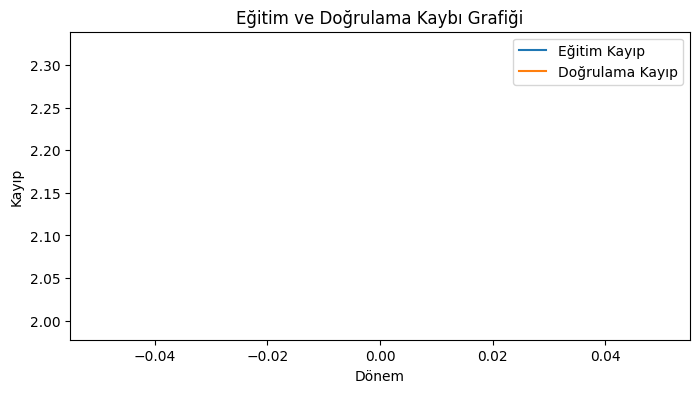

In [68]:
# Kayıp fonksiyonu grafiği
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.xlabel('Dönem')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

Son olarak aşağıdaki kod, modelin tahminlerini yaparak gerçek etiketlerle karşılaştırır. Confusion matrix, doğru ve yanlış tahminlerin sayısını gösterirken, classification report ise doğruluk, precision, recall ve F1 skoru gibi metrikleri sunar. Bu bilgiler, modelin sınıflandırma performansını detaylı bir şekilde değerlendirmeye yardımcı olur.

144/144 ━━━━━━━━━━━━━━━━━━━━ 108s 750ms/step


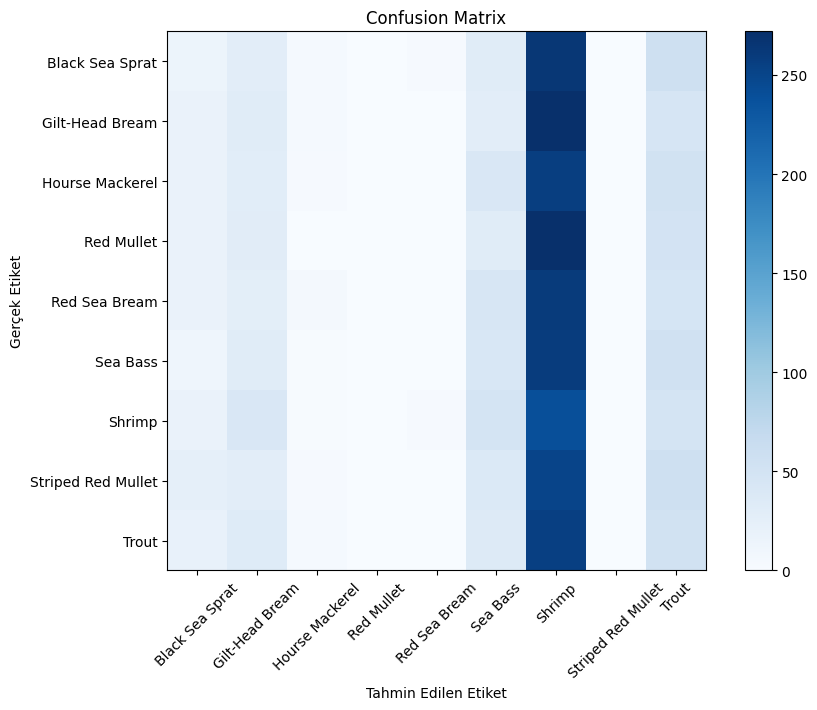

                    precision    recall  f1-score   support

   Black Sea Sprat       0.09      0.04      0.05       400
   Gilt-Head Bream       0.11      0.08      0.09       400
   Hourse Mackerel       0.11      0.01      0.01       400
        Red Mullet       0.00      0.00      0.00       400
     Red Sea Bream       0.10      0.00      0.00       400
          Sea Bass       0.12      0.10      0.11       400
            Shrimp       0.10      0.60      0.18       400
Striped Red Mullet       0.00      0.00      0.00       400
             Trout       0.11      0.13      0.12       400

          accuracy                           0.11      3600
         macro avg       0.08      0.11      0.06      3600
      weighted avg       0.08      0.11      0.06      3600



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# Tahminlerin Yapılması
Y_pred = model_ann.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Gerçek Etiketlerin Alınması
y_true = validation_generator.classes

# Confusion Matrix Hesaplama
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix Grafiği
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, validation_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, validation_generator.class_indices.keys())
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))